# Estimation of mass of catalyst required from the data read from Aspen Simulation 

In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import os
import win32com.client as win32

### Reading data from Aspen

In [3]:
""" ACCESSING ASPEN PLUS THROUGH COM """
aspen_v2 = win32.Dispatch("apwn.Document")

""" Specify the path of ASPEN PLUS BACKUP FILE TO BE ACCESSED HERE """
aspen_v2.InitFromArchive2(os.path.abspath('\\Users\\sirigina\\OneDrive - KTH\\Aspen\\Aspen sim files\\MGM-NEGAF_v2_file for Emma data.bkp'))

### Reading data from existing simulation 

In [4]:
""" Reading data from ASPEN Plus Simulation """

aspen_v2.Engine.Run2()
if aspen_v2.Tree.FindNode("\Data\Results Summary\Run-Status\Output\PER_ERROR").Dimension == 1:
    for element in aspen_v2.Tree.FindNode("\Data\Results Summary\Run-Status\Output\PER_ERROR").Elements:
        print(element.Value)
    print("\n")

#Inlet feed flow rate (l/min)     
#inlet_feed_flowrate = aspen_v2.Tree.FindNode("\Data\Blocks\BLO\Stream Results\Table\Total Flow l/min BLO-I").Value
#print("inlet total volumetric flow rate is {} l/min".format(inlet_feed_flowrate))

#CH4 feed molar flow rate to the reactor (mol/s)
inlet_ch4_feed_molar_flowrate = (aspen_v2.Tree.FindNode("\Data\Streams\HTR-O\Output\MOLEFLOW\MIXED\CH4").Value)*1000
print("inlet_ch4_feed_molar_flowrate is {}".format(inlet_ch4_feed_molar_flowrate))

# Inlet total pressure to the reactor (Pa or N/sqm)
inlet_total_pressure = aspen_v2.Tree.FindNode("\Data\Streams\HTR-O\Output\PRES_OUT\MIXED").Value
print("inlet_total_pressure is {}".format(inlet_total_pressure))

# Inlet CH4 mole fraction to the reactor (-)
inlet_CH4_frac = aspen_v2.Tree.FindNode("\Data\Streams\HTR-O\Output\MOLEFRAC\MIXED\CH4").Value
print("inlet_CH4_frac is {}".format(inlet_CH4_frac))

# Inlet partial pressure of H2O (Pa or N/sqm)
inlet_h2o_partial_pressure = aspen_v2.Tree.FindNode("\Data\Streams\HTR-O\Output\MOLEFRAC\MIXED\H2O").Value*inlet_total_pressure
print("inlet_h2o_partial_pressure is {}".format(inlet_h2o_partial_pressure))

# Inlet partial pressure of CH4 (Pa or N/sqm)
inlet_ch4_partial_pressure = inlet_CH4_frac*inlet_total_pressure
print("inlet_ch4_partial_pressure is {}".format(inlet_ch4_partial_pressure))

# Alpha of H2O - defined as the ratio of inlet partial pressure of H2O to inlet partial pressure of CH4
alpha_h2o = inlet_h2o_partial_pressure/inlet_ch4_partial_pressure
print("alpha_h2o is {}".format(alpha_h2o))



The following messages were issued during Input Translation:

   INFORMATION
   THERE ARE HENRY COMPONENTS DEFINED IN THIS CASE, THE BINARY DATABANK
   WILL BE SEARCHED AUTOMATICALLY FOR ANY AVAILABLE HENRY CONSTANTS.


inlet_ch4_feed_molar_flowrate is 0.0242990633
inlet_total_pressure is 116900.737
inlet_CH4_frac is 0.00301422212
inlet_h2o_partial_pressure is 637.0351225251349
inlet_ch4_partial_pressure is 352.3647873097024
alpha_h2o is 1.807885309394518


### Kinetic model for Catalyst estimation 

In [5]:
""" 

    Kinetic equation for steady state conversion of methane in a fixed bed reactor at the given temperatures
    T = Temperature at which the reaction is happening (C)
    F0 = Initial flow rate of gas feed (including Oxygen, and other inert gases)
    y0_CH4 = Mole fraction of methane in feed flow (Same as volume fraction under ideal gas assumption) 
    RH = Relative humidity in fraction
    
    The model and data is taken from 
    Alyani, M., & Smith, K. J. (2016). Kinetic Analysis of the Inhibition of CH4 Oxidation by H2O on PdO/Al2O3 and CeO2/PdO/Al2O3 Catalysts. 
    Industrial & Engineering Chemistry Research, 55(30), 8309-8318. 
    https://doi.org/10.1021/acs.iecr.6b01881 
    

    The input data for the model is read directly from the simulation. Alternatively, the data can be provided manually to
    the function below.
    
"""

def model(x_CH4,W, T, F0_CH4, y0_CH4, alpha, P0):
    
    
    """Internal effectiveness factor"""
    int_eff_factor_dict = {300: 0.47, 330: 0.36, 350: 0.3, 380: 0.24}
    int_eff_factor = int_eff_factor_dict[T]
    
    """ Rate constant (mol.g_Cat.mol_site-2.Pa-1.s-1)"""
    k_s_dict = {300 : 7.2, 330: 13.5, 350: 19.9, 380: 0.24}
    k_s = k_s_dict[T] # Rate constant 
    
    """Water adsoprtion equilibrium constant (Pa-1)"""
    K_H20_dict = {300: 1.25*10**-2, 330: 5.32*10**-3, 350: 3.16*10**-3, 380: 1.53*10**-3}
    K_H20 = K_H20_dict[T]
    
    """Total sites per gram of catalyst (mol_site.g_cat-1)"""
    C_T = 2.04 * (10**-4)
    
    """Total pressure"""
    P0 = P0
    
    """Ratio of partial pressure of H2O to CH4 at the inlet of the reactor"""
    alpha_H20 = alpha
    
    
    dx_CH4dW = (int_eff_factor*k_s*(C_T**2)*P0*(1-x_CH4)*y0_CH4)/((1+ (K_H20*P0*(alpha_H20+2*x_CH4)*y0_CH4) ) * F0_CH4)
    
    return dx_CH4dW

### Using the model to print the amount of catalyst for a given conversion

In [6]:
""" Amount of catalyst (g) for a particular conversion value
    W - Amount of catalyst for a given conversion value (g). A guess value should be given.
    X - Conversion required (fraction)
    T - Isothermal temperature of the reaction (C)
    F0 - Total flow rate of feed gas (mol.s-1)
    y0_CH4 - Mole fraction of methane in inlet air (fraction)
    RH - Relative humi dity in inlet air at 298.15K (%)"""

"""  ***WARNING*** in fsolve enter the initial value carefully, check the above mass - conversion values to get an estimate and 
                    enter the value close to it"""
def amount(W,X,T, F0, y0_CH4, alpha, inlet_total_pressure):
    t = np.linspace(0, W[0])
    y1 = odeint(model, 0, t, (T,F0, y0_CH4, alpha, inlet_total_pressure))
    return X-y1[-1]
print ("Amount of catalyst required for {}% conversion of methane is {}g".format(0.95*100, float(fsolve(amount,7000, args = (0.95,330,inlet_ch4_feed_molar_flowrate,inlet_CH4_frac, alpha_h2o, inlet_total_pressure)))))

Amount of catalyst required for 95.0% conversion of methane is 7098.099245258375g


### Conversion with mass of catalyst

For the conversion [0.], the mass of catalyst is 0.0 g
For the conversion [0.04742881], the mass of catalyst is 0.71007100710071 g
For the conversion [0.09481594], the mass of catalyst is 1.42014201420142 g
For the conversion [0.14216146], the mass of catalyst is 2.13021302130213 g
For the conversion [0.18946545], the mass of catalyst is 2.84028402840284 g
For the conversion [0.23672794], the mass of catalyst is 3.55035503550355 g
For the conversion [0.28394902], the mass of catalyst is 4.26042604260426 g
For the conversion [0.33112876], the mass of catalyst is 4.97049704970497 g
For the conversion [0.37826722], the mass of catalyst is 5.68056805680568 g
For the conversion [0.42536449], the mass of catalyst is 6.390639063906391 g
For the conversion [0.47242063], the mass of catalyst is 7.1007100710071 g
For the conversion [0.51943573], the mass of catalyst is 7.81078107810781 g
For the conversion [0.56640984], the mass of catalyst is 8.52085208520852 g
For the conversion [0.61334305], 

For the conversion [60.06917144], the mass of catalyst is 1779.4379437943794 g
For the conversion [60.08169089], the mass of catalyst is 1780.14801480148 g
For the conversion [60.09420553], the mass of catalyst is 1780.8580858085807 g
For the conversion [60.10671536], the mass of catalyst is 1781.5681568156815 g
For the conversion [60.11922039], the mass of catalyst is 1782.2782278227821 g
For the conversion [60.13172062], the mass of catalyst is 1782.988298829883 g
For the conversion [60.14421604], the mass of catalyst is 1783.6983698369836 g
For the conversion [60.15670667], the mass of catalyst is 1784.4084408440842 g
For the conversion [60.16919251], the mass of catalyst is 1785.118511851185 g
For the conversion [60.18167356], the mass of catalyst is 1785.8285828582857 g
For the conversion [60.19414981], the mass of catalyst is 1786.5386538653863 g
For the conversion [60.20662128], the mass of catalyst is 1787.2487248724872 g
For the conversion [60.21908797], the mass of catalyst i

For the conversion [82.876084], the mass of catalyst is 3837.223722372237 g
For the conversion [82.88084062], the mass of catalyst is 3837.9337933793377 g
For the conversion [82.88559581], the mass of catalyst is 3838.6438643864385 g
For the conversion [82.89034957], the mass of catalyst is 3839.353935393539 g
For the conversion [82.89510189], the mass of catalyst is 3840.0640064006398 g
For the conversion [82.89985278], the mass of catalyst is 3840.7740774077406 g
For the conversion [82.90460224], the mass of catalyst is 3841.4841484148415 g
For the conversion [82.90935027], the mass of catalyst is 3842.194219421942 g
For the conversion [82.91409686], the mass of catalyst is 3842.9042904290427 g
For the conversion [82.91884202], the mass of catalyst is 3843.6143614361436 g
For the conversion [82.92358576], the mass of catalyst is 3844.324432443244 g
For the conversion [82.92832806], the mass of catalyst is 3845.034503450345 g
For the conversion [82.93306894], the mass of catalyst is 3

For the conversion [91.99856299], the mass of catalyst is 5831.813181318132 g
For the conversion [92.00068864], the mass of catalyst is 5832.5232523252325 g
For the conversion [92.00281371], the mass of catalyst is 5833.2333233323325 g
For the conversion [92.0049382], the mass of catalyst is 5833.943394339433 g
For the conversion [92.0070621], the mass of catalyst is 5834.653465346534 g
For the conversion [92.00918541], the mass of catalyst is 5835.363536353635 g
For the conversion [92.01130814], the mass of catalyst is 5836.073607360736 g
For the conversion [92.01343028], the mass of catalyst is 5836.783678367837 g
For the conversion [92.01555183], the mass of catalyst is 5837.493749374938 g
For the conversion [92.0176728], the mass of catalyst is 5838.2038203820375 g
For the conversion [92.01979319], the mass of catalyst is 5838.913891389138 g
For the conversion [92.02191299], the mass of catalyst is 5839.623962396239 g
For the conversion [92.02403221], the mass of catalyst is 5840.3

Text(0, 0.5, 'Conversion in the reactor (-)')

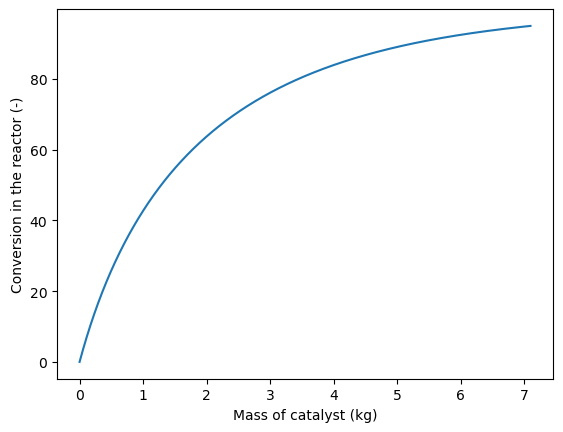

In [10]:
W = np.linspace(0,7100,10000)
y = odeint(model, 0, W, (330,inlet_ch4_feed_molar_flowrate,inlet_CH4_frac, alpha_h2o, inlet_total_pressure))
for i,j in zip(y,W):
    print ("For the conversion {}, the mass of catalyst is {} g".format(i*100,j))
plt.plot(W/1000,y*100)
plt.xlabel("Mass of catalyst (kg)")
plt.ylabel("Conversion in the reactor (-)")

In [8]:
""" Reinitialising and closing the simulation """
aspen_v2.Reinit()

In [9]:
aspen_v2.Close()